# Model Training

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run
import numpy as np

In [ ]:
import os

os.getcwd()

'c:\\Users\\ybrot\\Desktop\\course\\UROP\\GAGEii_modeling'

In [ ]:
start_run(config_file=Path('config.yml'))

2025-02-18 10:49:22,317: Logging to c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-ALL_US_with_static_minmax_standardized_1802_104922\output.log initialized.
2025-02-18 10:49:22,318: ### Folder structure created at c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-ALL_US_with_static_minmax_standardized_1802_104922
2025-02-18 10:49:22,318: ### Run configurations for GAGEii-ALL_US_with_static_minmax_standardized
2025-02-18 10:49:22,319: experiment_name: GAGEii-ALL_US_with_static_minmax_standardized
2025-02-18 10:49:22,319: run_dir: c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-ALL_US_with_static_minmax_standardized_1802_104922
2025-02-18 10:49:22,319: train_basin_file: C:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\basin_list\US_basin_list.txt
2025-02-18 10:49:22,320: validation_basin_file: C:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\basin_list\US_basin_list.txt
2025-02-18 10:49:22,320: test_basin_file: C:\Users\ybrot\Desktop\cours

In [ ]:
from resources.file_conversion import DataFrame_to_CDF
from tqdm import tqdm
import pandas as pd
import os

def convert_csv_to_cdf(input_folder: str, output_folder: str):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
    
    for csv_file in tqdm(csv_files):
        # Construct the file path for the CSV file
        csv_file_path = os.path.join(input_folder, csv_file)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path, index_col='date')
        df.index = pd.to_datetime(df.index)
        
        # Convert the DataFrame to a CDF file
        basin_id = os.path.splitext(csv_file)[0]
        DataFrame_to_CDF(df, output_folder, basin_id)


In [ ]:
input_folder = './data/z-standardized_csv_files'
output_folder = './data/time_series'
convert_csv_to_cdf(input_folder, output_folder)

In [ ]:
start_run(config_file=Path('config_backup.yml'))

# Evaluation

In [50]:
run_dir = Path("runs/GAGEii-ALL_US_with_static_1602_133919") 
eval_run(run_dir=run_dir, period="test")

with open(run_dir / "test" / "model_epoch100" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)

C:\Users\ybrot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub f

# Evaluation:   7%|▋         | 29/399 [00:07<01:30,  4.08it/s]


KeyboardInterrupt: 

In [51]:
# Load results once and reuse
if 'results' not in globals():
    with open(run_dir / "test" / "model_epoch100" / "test_results.p", "rb") as fp:
        results = pickle.load(fp)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `results` is already loaded with subbasin data.

# Extract subbasin keys
subbasin_keys = list(results.keys())

# Initialize lists to store NSE values and subbasin IDs
nse_values = []
subbasin_ids = []

# Loop through each subbasin and collect NSE values
for key in subbasin_keys:
    
    if 'NSE' not in results[key]['1D']:
        print(f"Skipping {key} as it does not have 1D results.")
        continue
    
    nse = results[key]['1D']['NSE']
    nse_values.append(nse)
    subbasin_ids.append(key)

# Convert to a DataFrame for easier manipulation and visualization
nse_df = pd.DataFrame({'Subbasin': subbasin_ids, 'NSE': nse_values})

# Statistical Summary
summary_stats = nse_df['NSE'].describe()


Skipping 04240503 as it does not have 1D results.


C:\Users\ybrot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [53]:
summary_stats   

count    398.000000
mean           -inf
std             NaN
min            -inf
25%       -8.637053
50%        0.447354
75%        0.737577
max        0.892988
Name: NSE, dtype: float64

In [54]:
nse_df['Performance'] = nse_df['NSE'].apply(lambda x: 'Excellent' if x > 0.75 else 'Good' if x >= 0.36 else 'Unsatisfactory' if x >= 0 else 'Negative')
nse_df['Performance'].value_counts()

Performance
Negative          161
Good              122
Excellent          85
Unsatisfactory     30
Name: count, dtype: int64

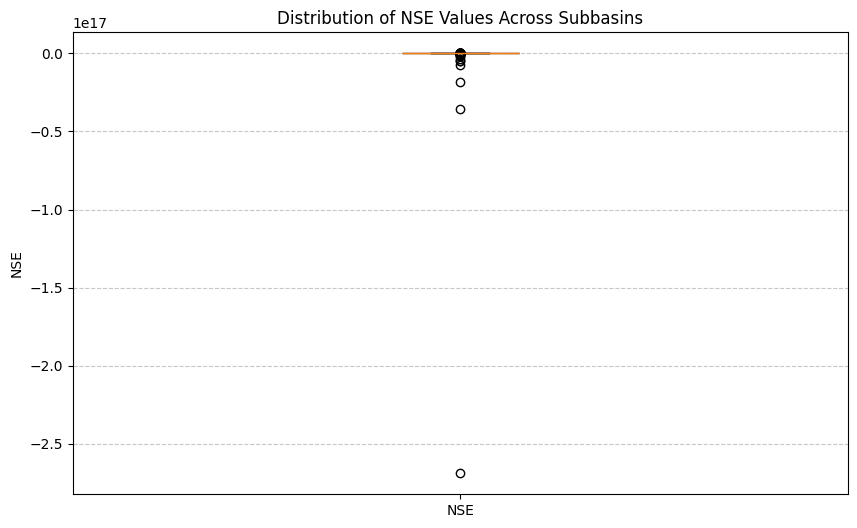

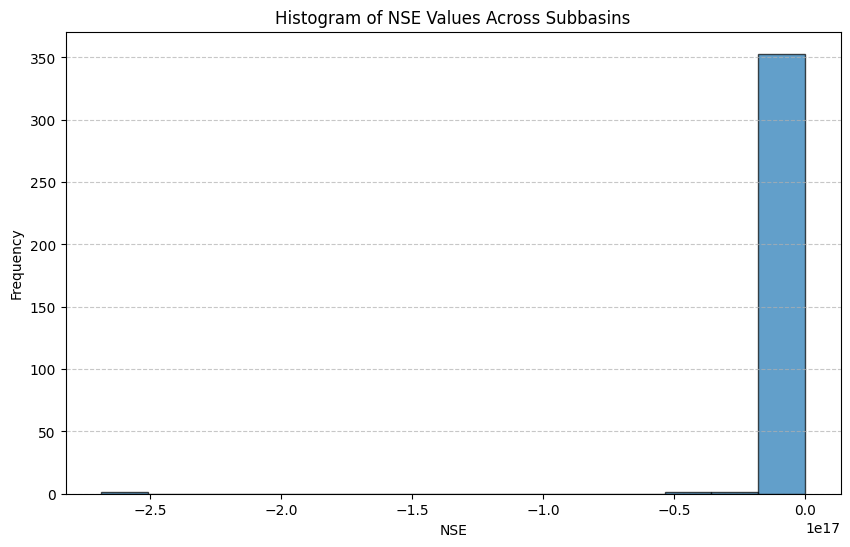

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out -inf values
nse_values = nse_df['NSE'].replace(-np.inf, np.nan).dropna()

# Plot: Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(nse_values, vert=True, patch_artist=True, labels=['NSE'])
plt.title("Distribution of NSE Values Across Subbasins")
plt.ylabel("NSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot: Histogram
plt.figure(figsize=(10, 6))
plt.hist(nse_values, bins=15, edgecolor='black', alpha=0.7)
plt.title("Histogram of NSE Values Across Subbasins")
plt.xlabel("NSE")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
min_nse_row = nse_df.loc[nse_df['Performance'] == 'Unsatisfactory']
min_nse_row

,Subbasin,NSE,Performance
11,04025500,0.348737,Unsatisfactory
14,04029990,0.181302,Unsatisfactory
29,04043150,0.275608,Unsatisfactory
34,04044724,0.319316,Unsatisfactory
40,04057800,0.267480,Unsatisfactory
41,04058100,0.139050,Unsatisfactory
46,04060500,0.008135,Unsatisfactory
50,04062000,0.349785,Unsatisfactory
72,04071765,0.012231,Unsatisfactory
84,04077630,0.250791,Unsatisfactory


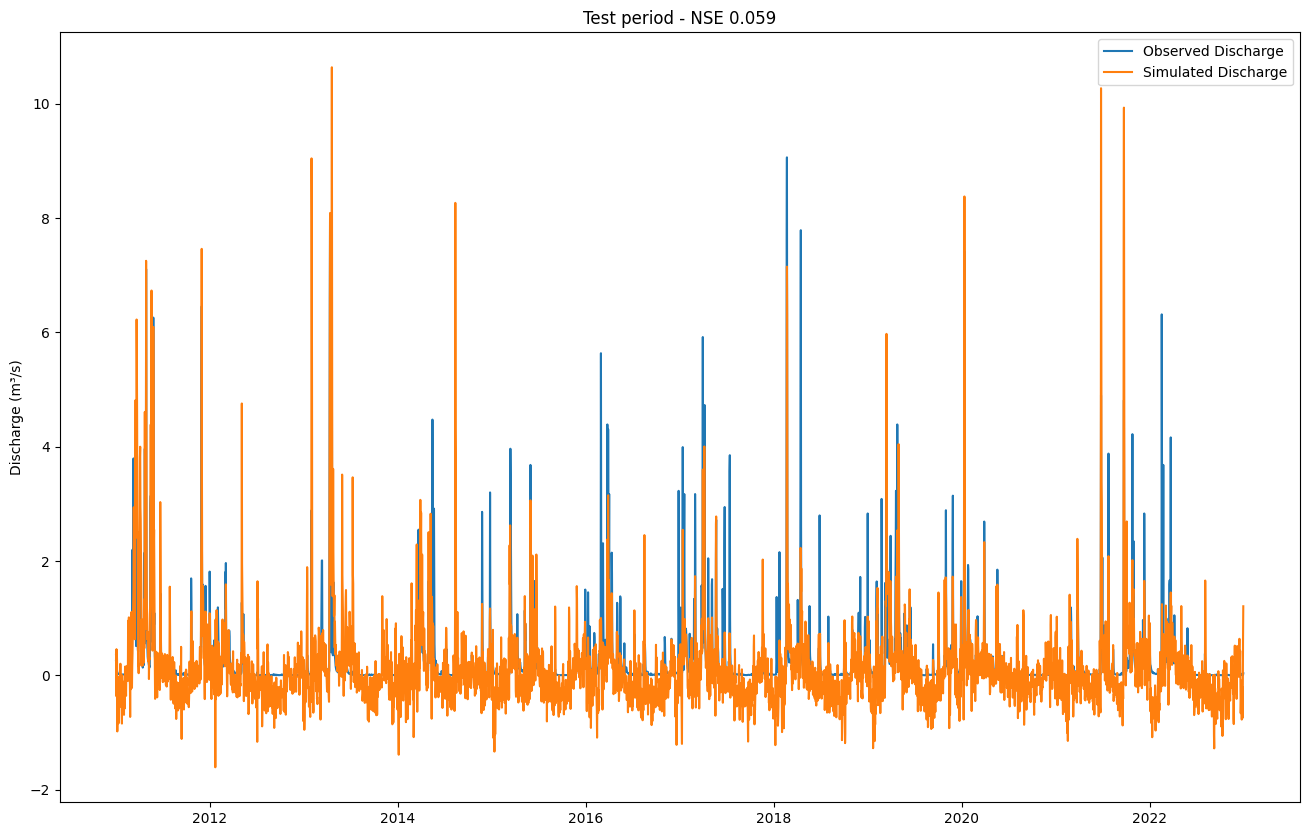

In [ ]:
# extract observations and simulations
qobs = results['04164300']['1D']['xr']['discharge_obs']
qsim = results['04164300']['1D']['xr']['discharge_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs, label='Observed Discharge')
ax.plot(qsim['date'], qsim, label='Simulated Discharge')
ax.set_ylabel("Discharge (m³/s)")
ax.set_title(f"Test period - NSE {results['04164300']['1D']['NSE']:.3f}")
ax.legend()  # Add legend to indicate which line is which

In [53]:
 results['04043050']['1D']['xr']['discharge_obs'].values

array([[0.9542694 ],
       [0.96276283],
       [0.96276283],
       ...,
       [0.8636551 ],
       [0.8636551 ],
       [0.8636551 ]], dtype=float32)

# Evaluation after inverse-transforming the predictions

In [68]:
import numpy as np
import pandas as pd
import os

def evaluate_basin_prediction(basin_id: str, run_dir: str, epoch_num: int, 
                              csv_dir: str = "data/csv_files",
                              test_start_date: str = '01/01/2011',
                              test_end_date: str = '31/12/2022',
                              draw_graph: bool = True,
                              min_max: bool = False,
                              skip_eval: bool = False,
                              apply_transformation: bool = True) -> float:
    
    
    
    run_dir = Path("runs/" + run_dir)
    
    if not skip_eval:
        eval_run(run_dir=run_dir, period="test")
    
    # set the epoch number
    epoch_num = str(epoch_num)
    if len(epoch_num) == 1:
        epoch_num = "model_epoch00" + epoch_num
    elif len(epoch_num) == 2:
        epoch_num = "model_epoch0" + epoch_num
    else:
        epoch_num = "model_epoch" + epoch_num
    
    # evaluation
    with open(run_dir / "test" / epoch_num / "test_results.p", "rb") as fp:
        results = pickle.load(fp)
        
    # simulated values
    qsim = results[basin_id]['1D']['xr']['discharge_sim']
    qsim_values = qsim.values
    
    if apply_transformation:
        if min_max:
            min = -13.815510557964274
            max = 8.070835295146114
            
            inverted_qsim_values = qsim_values * (max - min) + min
        else:
            # invert the standardization
            mean = 0.8561527661255196
            var = 5.06157279557463

            inverted_qsim_values = (qsim_values * np.sqrt(var)) + mean
            
        # Invert the log transformation
        inverted_qsim_values = np.exp(inverted_qsim_values) - 1e-6
            
    else:
        inverted_qsim_values = qsim_values
    
    
    
    # Read the CSV file as a dataframe
    csv_file_path = Path(csv_dir) / f"{basin_id}.csv"
    df = pd.read_csv(csv_file_path, index_col='date', parse_dates=True)
    
    # Filter the dataframe for the specified date range and select the "discharge" column
    df_filtered = df.loc[test_start_date:test_end_date, ['discharge']]
    
    # Calculate NSE
    observed_values = df_filtered['discharge'].values
    simulated_values = inverted_qsim_values[:len(observed_values)]  # Ensure the lengths match
    
    mean_observed = np.mean(observed_values)
    sum_squared_diff = sum((obs - sim) ** 2 for obs, sim in zip(observed_values, simulated_values))
    mean_observed = np.mean(observed_values)
    sum_squared_diff_mean = sum((obs - mean_observed) ** 2 for obs in observed_values)

    if sum_squared_diff_mean == 0:
        # Observed data is constant => no variability => NSE is undefined
        nse = np.nan  # or some sentinel value
    else:
        nse = 1 - (sum_squared_diff / sum_squared_diff_mean)
        nse = nse.item()
    
    if draw_graph:
        fig, ax = plt.subplots(figsize=(16,10))
        ax.plot(qsim['date'], observed_values, label='Observed Discharge')
        ax.plot(qsim['date'], inverted_qsim_values, label='Simulated Discharge')
        ax.set_ylabel("Discharge (m³/s)")
        ax.set_title(f"Test period - NSE {nse:.3f}")
        ax.legend()
    
    return nse, observed_values, simulated_values, qsim['date']
    
    
    

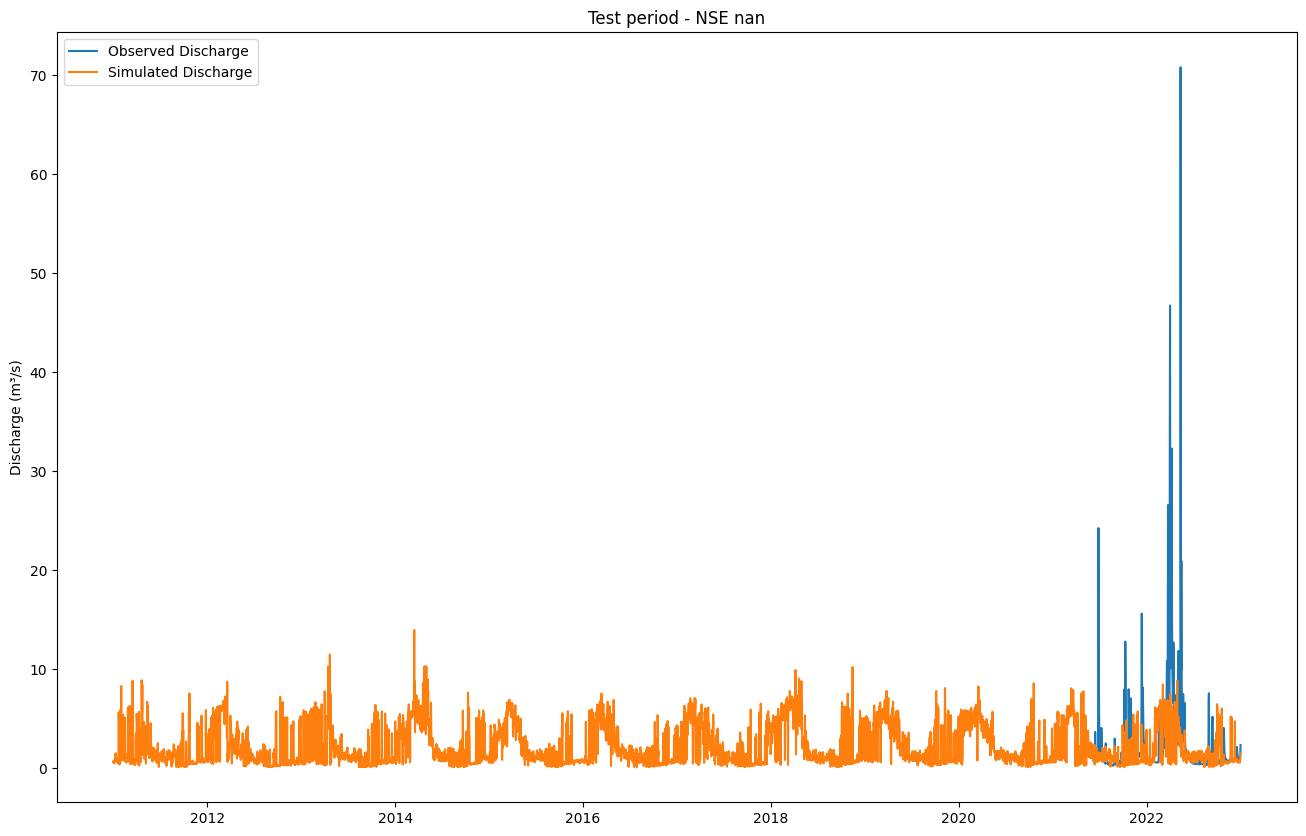

In [51]:
basin_id = "04153500"
run_dir = "GAGEii-ALL_US_with_static_minmax_standardized_1902_061410"
epoch_num = 100

nse, obs, sim, dates = evaluate_basin_prediction(basin_id, run_dir, epoch_num, min_max=True, skip_eval=True, apply_transformation=True)

In [58]:
basin_id = "04034500"
csv_file_path = Path("data/csv_files") / f"{basin_id}.csv"
df = pd.read_csv(csv_file_path, index_col='date', parse_dates=True)

In [59]:
df

,discharge,dayl,prcp,srad,swe,tmax,tmin,vp
date,,,,,,,,
1980-01-01,1.302563,30541.043,0.000000,68.643280,28.664677,-1.808412,-5.277130,412.58320
1980-01-02,1.245929,30594.625,0.000000,75.579700,28.664677,-4.927762,-8.721642,316.24554
1980-01-03,1.217613,30652.557,0.000000,160.346450,28.664677,-5.938195,-15.024441,190.50478
1980-01-04,1.245929,30714.809,0.000000,214.180770,28.664677,-8.031985,-25.176805,78.92706
1980-01-05,1.274246,30781.318,4.979116,147.285540,33.643738,-5.739188,-16.562782,167.71010
...,...,...,...,...,...,...,...,...
2023-12-27,2.769361,30339.834,0.000000,68.957634,0.000000,1.697310,-1.777960,536.22390
2023-12-28,2.769361,30371.008,0.000000,66.018610,0.000000,0.767599,-2.490578,508.60898
2023-12-29,2.769361,30406.723,0.000000,142.806230,0.000000,3.756517,-4.390866,441.36816


In [60]:
df.isnull().sum()

discharge    0
dayl         0
prcp         0
srad         0
swe          0
tmax         0
tmin         0
vp           0
dtype: int64

In [9]:
obs

array([0.95426872, 0.9627637 , 0.9627637 , ..., 0.86365567, 0.86365567,
       0.86365567])

In [24]:
sim.flatten().shape

(4383,)

In [25]:
dates['date'].values.shape

(4383,)

In [53]:
result_df = pd.DataFrame({
        'date': dates['date'].values,
        'observed': obs.flatten(),
        'simulated': sim.flatten()
    })

In [46]:
result_df

,date,observed,simulated
0,2011-01-01,0.243523,0.465596
1,2011-01-02,0.243523,0.427731
2,2011-01-03,0.243523,0.361105
3,2011-01-04,0.243523,0.449341
4,2011-01-05,0.243523,0.565247
...,...,...,...
4378,2022-12-27,0.243523,0.467106
4379,2022-12-28,0.243523,0.497841
4380,2022-12-29,0.243523,0.359936
4381,2022-12-30,0.243523,0.262606


In [54]:
result_df.isna().sum()

date            0
observed     3812
simulated       0
dtype: int64

In [55]:
result_df_cleaned = result_df.dropna()
result_df_cleaned

,date,observed,simulated
3812,2021-06-09,0.665440,0.837525
3813,2021-06-10,0.608806,0.632280
3814,2021-06-11,0.651281,1.670349
3815,2021-06-12,1.257256,0.366563
3816,2021-06-13,2.517344,2.319552
...,...,...,...
4378,2022-12-27,0.736231,0.799603
4379,2022-12-28,0.756053,0.555996
4380,2022-12-29,0.815517,0.811662
4381,2022-12-30,1.245929,1.028656


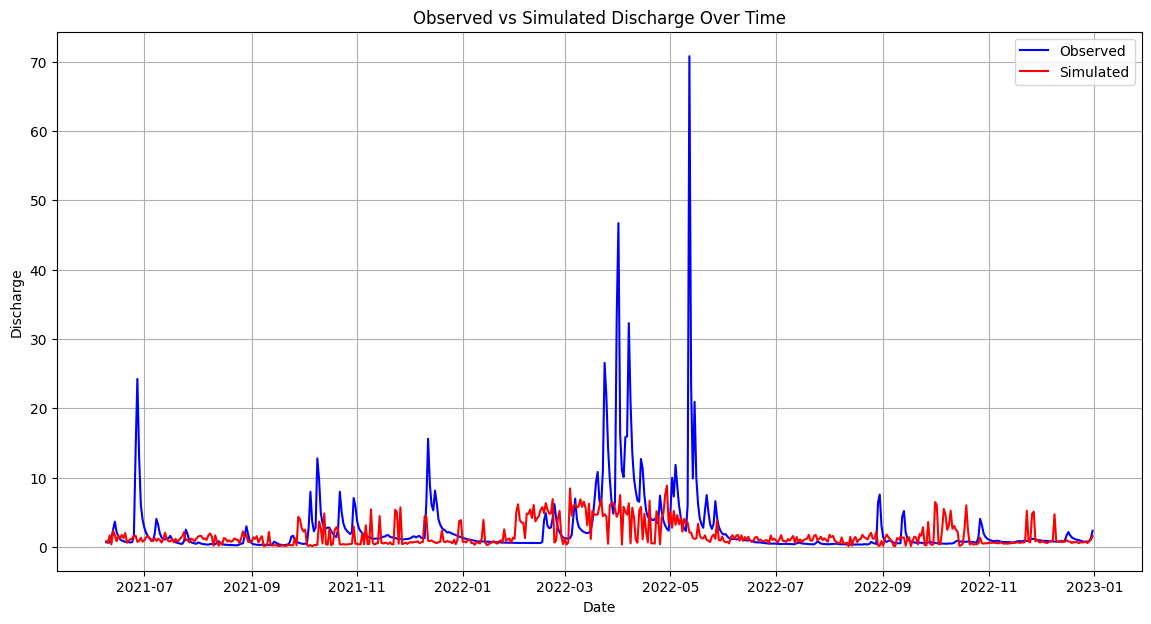

In [57]:
plt.figure(figsize=(14, 7))
plt.plot(result_df_cleaned['date'], result_df_cleaned['observed'], label='Observed', color='blue')
plt.plot(result_df_cleaned['date'], result_df_cleaned['simulated'], label='Simulated', color='red')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Observed vs Simulated Discharge Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate Multiple Basins

In [69]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def evaluate_multiple_basins(eval_list: str, run_dir: str, epoch_num: int, 
                              csv_dir: str = "data/csv_files",
                              test_start_date: str = '01/01/2011',
                              test_end_date: str = '31/12/2022',
                              draw_graph: bool = True,
                              min_max: bool = False,
                              skip_eval: bool = False,
                              apply_transformation = True) -> pd.DataFrame:
    
    # Read the basin IDs from the eval_list file
    with open(eval_list, 'r') as file:
        basin_ids = file.read().splitlines()
    
    nse_values = []
    
    evaluate_basin_prediction(basin_id=basin_ids[0], 
                              run_dir=run_dir, 
                              epoch_num=epoch_num,
                              csv_dir=csv_dir,
                              test_start_date=test_start_date,
                              test_end_date=test_end_date,
                              draw_graph=False,
                              min_max=min_max,
                              skip_eval=skip_eval,
                              apply_transformation=apply_transformation)
    
    
    for basin_id in tqdm(basin_ids):
        nse, _, _, _ = evaluate_basin_prediction(basin_id, 
                              run_dir=run_dir, 
                              epoch_num=epoch_num,
                              csv_dir=csv_dir,
                              test_start_date=test_start_date,
                              test_end_date=test_end_date,
                              draw_graph=False,
                              min_max=min_max,
                              skip_eval=True,
                              apply_transformation=apply_transformation)
        nse_values.append(nse)
        
    nse_df = pd.DataFrame({'basin_id': basin_ids, 'NSE': nse_values})

    
    if draw_graph:
        
        print(f"Summary Statistic: \n{nse_df['NSE'].replace(-np.inf, np.nan).dropna().describe()}\n")
        
        nse_df['Performance'] = nse_df['NSE'].apply(lambda x: 'Excellent' if x > 0.75 else 'Good' if x >= 0.36 else 'Unsatisfactory' if x >= 0 else 'Negative')
        
        print(f"Performance Summary: \n{nse_df['Performance'].value_counts()}\n")
        
        
    # Plot: Box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot(nse_df['NSE'].replace(-np.inf, np.nan).dropna(), vert=True, patch_artist=True, labels=['NSE'])
    plt.title("Distribution of NSE Values Across Subbasins")
    plt.ylabel("NSE")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot: Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(nse_df['NSE'].replace(-np.inf, np.nan).dropna(), bins=10, edgecolor='black', alpha=0.7)
    plt.title("Histogram of NSE Values Across Subbasins")
    plt.xlabel("NSE")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
        
    
    return nse_df
    
    
    
    

100%|██████████| 399/399 [00:33<00:00, 11.76it/s]

Summary Statistic: 
count    3.470000e+02
mean    -1.976361e+32
std      2.631673e+33
min     -4.796612e+34
25%     -2.331096e-01
50%      6.215861e-01
75%      7.614262e-01
max      8.983960e-01
Name: NSE, dtype: float64

Performance Summary: 
Performance
Negative          158
Good              119
Excellent          95
Unsatisfactory     27
Name: count, dtype: int64



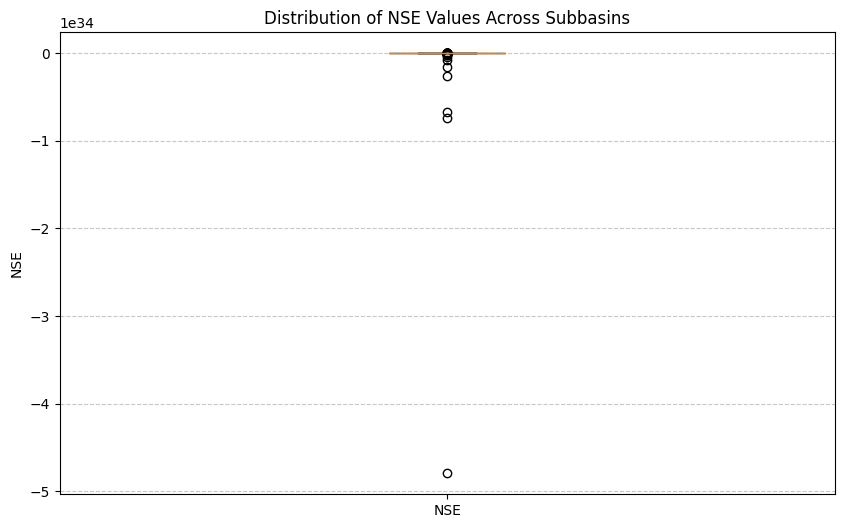

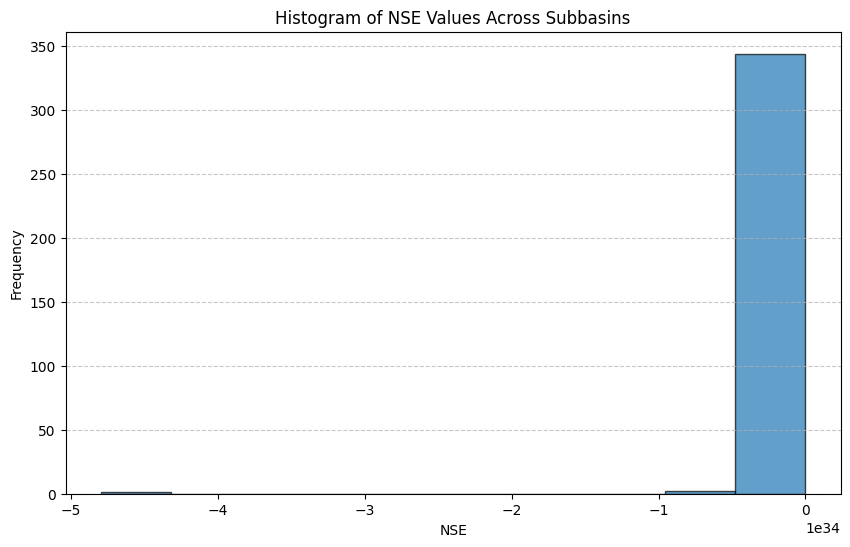

In [73]:
eval_list: str = r"basin_list\US_basin_list.txt"
run_dir = "GAGEii-ALL_US_with_static_z_standardized_1902_141922"
epoch_num = 89

df = evaluate_multiple_basins(eval_list, run_dir, epoch_num, min_max=False, skip_eval=True)

In [74]:
df

,basin_id,NSE,Performance
0,03115973,-5.588744e+00,Negative
1,04014500,NaN,Negative
2,04015330,5.398749e-01,Good
3,04015500,-4.354755e+29,Negative
4,04016000,-2.877360e+29,Negative
...,...,...,...
394,04257000,-2.923478e+30,Negative
395,04258000,5.266503e-01,Good
396,04260500,8.484460e-01,Excellent
397,04263000,7.052814e-01,Good


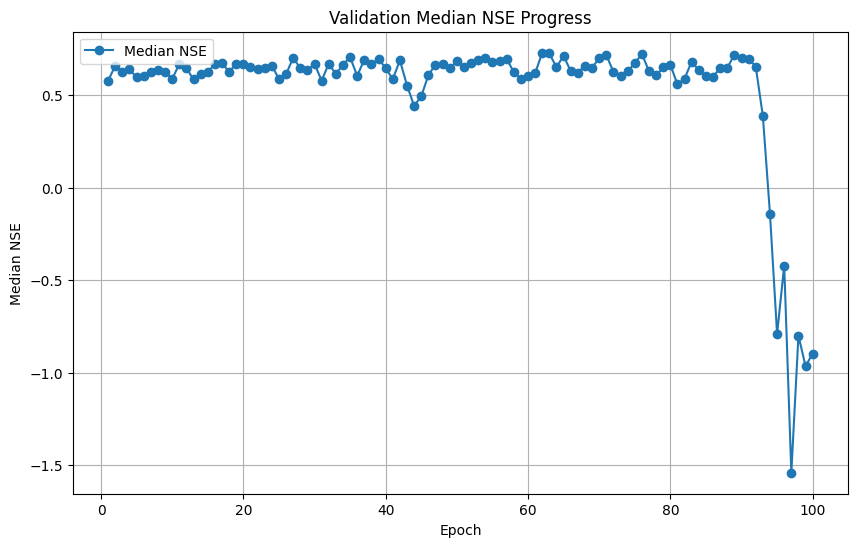

    Epoch  Mean NSE  Median NSE   Max NSE
0       1      -inf    0.578566  0.875217
1       2      -inf    0.660511  0.883162
2       3      -inf    0.628420  0.885251
3       4      -inf    0.640016  0.898094
4       5      -inf    0.596902  0.903408
..    ...       ...         ...       ...
95     96      -inf   -0.421969  0.678279
96     97      -inf   -1.542073  0.542739
97     98      -inf   -0.800277  0.373444
98     99      -inf   -0.965816  0.315226
99    100      -inf   -0.897385  0.327910

[100 rows x 4 columns]


In [76]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def collect_nse_statistics(validation_folder, num_epochs):
    mean_nse_values = []
    median_nse_values = []
    max_nse_values = []

    for epoch in range(1, num_epochs + 1):
        epoch_folder = os.path.join(validation_folder, f"model_epoch{epoch:03d}")
        csv_file = os.path.join(epoch_folder, "validation_metrics.csv")

        if os.path.exists(csv_file):
            df = pd.read_csv(csv_file)
            mean_nse = df["NSE"].dropna().mean()
            median_nse = df["NSE"].dropna().median()
            max_nse = df["NSE"].dropna().max()
            mean_nse_values.append(mean_nse)
            median_nse_values.append(median_nse)
            max_nse_values.append(max_nse)
        else:
            mean_nse_values.append(None)
            median_nse_values.append(None)
            max_nse_values.append(None)

    return mean_nse_values, median_nse_values, max_nse_values

def plot_nse_progress(nse_values, plot_type):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(nse_values) + 1)
    plt.plot(epochs, nse_values, marker='o', label=f'{plot_type} NSE')
    plt.xlabel("Epoch")
    plt.ylabel(f"{plot_type} NSE")
    plt.title(f"Validation {plot_type} NSE Progress")
    plt.grid(True)
    plt.legend()
    plt.show()

def get_nse_dataframe(mean_nse_values, median_nse_values, max_nse_values):
    nse_df = pd.DataFrame({
        "Epoch": range(1, len(mean_nse_values) + 1),
        "Mean NSE": mean_nse_values,
        "Median NSE": median_nse_values,
        "Max NSE": max_nse_values
    })
    return nse_df

# Folder containing the validation subfolders
validation_folder = "runs/GAGEii-ALL_US_with_static_z_standardized_1902_141922/validation"

# Number of epochs (adjust this value as needed)
num_epochs = 100

# Collect NSE statistics
mean_nse_values, median_nse_values, max_nse_values = collect_nse_statistics(validation_folder, num_epochs)

# Plot NSE progress (specify which one to plot: 'Mean', 'Median', 'Max')
plot_type = 'Median'  # Change this to 'Median' or 'Max' as needed
if plot_type == 'Mean':
    plot_nse_progress(mean_nse_values, plot_type)
elif plot_type == 'Median':
    plot_nse_progress(median_nse_values, plot_type)
elif plot_type == 'Max':
    plot_nse_progress(max_nse_values, plot_type)

# Get NSE dataframe
nse_df = get_nse_dataframe(mean_nse_values, median_nse_values, max_nse_values)

# Display the dataframe
print(nse_df)